<a href="https://colab.research.google.com/github/38tter/nishika-second-hand-apartment-price-forecasting-2022-winter/blob/main/base_and_fill_na_and_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

from google.colab import files
files.upload()

Saving data.zip to data.zip


In [ ]:
import zipfile
with zipfile.ZipFile('data.zip') as z:
  z.extractall()

In [ ]:
import zipfile
with zipfile.ZipFile('train.zip') as z:
  z.extractall()

In [ ]:
!ls

data_explanation.xlsx  __MACOSX     sample_submission.csv  train
data.zip	       sample_data  test.csv		   train.zip


In [ ]:
from glob import glob
import pandas as pd

paths = glob('./train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
test_df = pd.read_csv('./test.csv')

In [ ]:
test_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1000001,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,25,４ＬＤＫ,...,住宅,NaN,NaN,NaN,第１種低層住居専用地域,40.0,80.0,2021年第1四半期,未改装,NaN
1,1000002,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,20,４ＬＤＫ,...,住宅,NaN,NaN,NaN,近隣商業地域,80.0,200.0,2021年第1四半期,未改装,NaN
2,1000066,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１１丁目,3,２ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2021年第1四半期,未改装,NaN
3,1000119,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2021年第1四半期,未改装,NaN
4,1000120,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,4,２ＬＤＫ,...,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN


In [ ]:
# すべての行が NaN のカラムを抽出する
line_length = len(train_df)
drop_columns = [val for val in train_df.isnull().sum().keys() if train_df[val].isnull().sum() == line_length]

In [ ]:
train_df = train_df.drop(drop_columns, axis=1)

In [ ]:
test_df = test_df.drop(drop_columns, axis=1)

In [ ]:
na_contained_keys = [key for key in train_df.keys() if len(train_df[train_df[key].isnull()]) > 0]

In [ ]:
na_contained_keys

['地区名',
 '最寄駅：名称',
 '最寄駅：距離（分）',
 '間取り',
 '建築年',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '建ぺい率（％）',
 '容積率（％）',
 '改装',
 '取引の事情等']

In [ ]:
train_df.drop('ID', axis=1)
test_df.drop('ID', axis=1)

,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,中古マンション等,1101,北海道,札幌市中央区,旭ケ丘,円山公園,25,４ＬＤＫ,85,昭和64年,ＲＣ,NaN,住宅,第１種低層住居専用地域,40.0,80.0,2021年第1四半期,未改装,NaN
1,中古マンション等,1101,北海道,札幌市中央区,旭ケ丘,円山公園,20,４ＬＤＫ,105,平成9年,ＲＣ,NaN,住宅,近隣商業地域,80.0,200.0,2021年第1四半期,未改装,NaN
2,中古マンション等,1101,北海道,札幌市中央区,大通西,西１１丁目,3,２ＬＤＫ,50,平成24年,ＲＣ,NaN,住宅,商業地域,80.0,600.0,2021年第1四半期,未改装,NaN
3,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,45,平成3年,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2021年第1四半期,未改装,NaN
4,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,4,２ＬＤＫ,55,昭和55年,ＳＲＣ,NaN,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22390,中古マンション等,47211,沖縄県,沖縄市,字美里,NaN,NaN,３ＬＤＫ,75,平成31年,ＲＣ,NaN,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN
22391,中古マンション等,47211,沖縄県,沖縄市,美里,NaN,NaN,２ＬＤＫ,65,平成30年,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2021年第1四半期,未改装,NaN
22392,中古マンション等,47211,沖縄県,沖縄市,美原,NaN,NaN,３ＬＤＫ,65,平成22年,ＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN
22393,中古マンション等,47211,沖縄県,沖縄市,与儀,NaN,NaN,NaN,60,平成29年,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2021年第1四半期,NaN,NaN


In [ ]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
            # ここも工夫できそう
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [ ]:
train_df['建築年'] = train_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
test_df['建築年'] = test_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))

In [ ]:
# base_and_fill_na の結果を見ると
# feature importance が高い keys は 
# 1. 建築年
# 2. 最寄駅：距離(分)
# なのでそこの欠損値の補間を工夫してみる

In [ ]:
train_df.corr()

,ID,市区町村コード,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
ID,1.000000,0.999942,-0.010064,0.055634,0.001248,-0.156123
市区町村コード,0.999942,1.000000,-0.009522,0.055914,0.001133,-0.157309
建築年,-0.010064,-0.009522,1.000000,0.129314,0.146005,0.539753
建ぺい率（％）,0.055634,0.055914,0.129314,1.000000,0.768723,0.025427
容積率（％）,0.001248,0.001133,0.146005,0.768723,1.000000,0.112121
取引価格（総額）_log,-0.156123,-0.157309,0.539753,0.025427,0.112121,1.000000


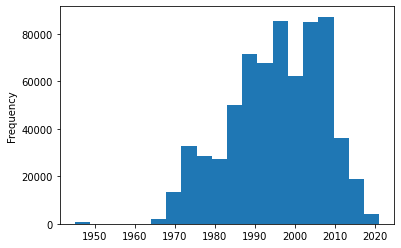

In [ ]:
train_df['建築年'].plot.hist(bins=20)

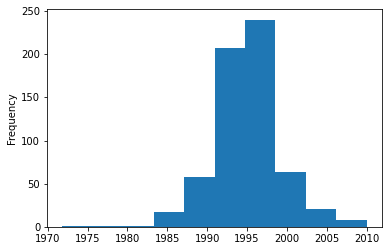

In [ ]:
train_df.groupby(['都道府県名', '市区町村名'])['建築年'].mean().plot.hist()
# 都道府県名と市区町村名でグループ化すると建築年は一定の広がりを持つ

In [ ]:
len(train_df) / len(train_df.groupby(['都道府県名', '市区町村名'])['建築年'])

1119.357027463651

In [ ]:
# 1 グループ平均 1100 件程度あり、平均値にも一定の確からしさがありそう
# よって建築年の NA 値は 都道府県名・市区町村名でグループ化した結果を使う

In [ ]:
# 地区名まで込みでグループ化するとどうなるかも気になる

In [ ]:
train_df.corr()

,ID,市区町村コード,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
ID,1.000000,0.999942,-0.010064,0.055634,0.001248,-0.156123
市区町村コード,0.999942,1.000000,-0.009522,0.055914,0.001133,-0.157309
建築年,-0.010064,-0.009522,1.000000,0.129314,0.146005,0.539753
建ぺい率（％）,0.055634,0.055914,0.129314,1.000000,0.768723,0.025427
容積率（％）,0.001248,0.001133,0.146005,0.768723,1.000000,0.112121
取引価格（総額）_log,-0.156123,-0.157309,0.539753,0.025427,0.112121,1.000000


In [ ]:
set(train_df.keys()) - set(train_df._get_numeric_data().keys())

{'今後の利用目的',
 '取引の事情等',
 '取引時点',
 '地区名',
 '市区町村名',
 '建物の構造',
 '改装',
 '最寄駅：名称',
 '最寄駅：距離（分）',
 '用途',
 '種類',
 '都市計画',
 '都道府県名',
 '間取り',
 '面積（㎡）'}

In [ ]:
train_df.groupby('都市計画')['建築年']

In [ ]:
constructed_year_dict = dict(train_df.groupby(['都道府県名', '市区町村名'])['建築年'].mean())
constructed_year_dict[('秋田県', '秋田市')]

1995.1297709923665

In [ ]:
def set_mean(row):
  return constructed_year_dict[(row['都道府県名'], row['市区町村名'])]

In [ ]:
# 以下はボツ案
# for key, value in constructed_year_dict.items():
#   train_df[ (train_df['都道府県名'] == key[0]) & (train_df['市区町村名'] == key[1])]['建築年'] = train_df[ (train_df['都道府県名'] == key[0]) & (train_df['市区町村名'] == key[1])]['建築年'].fillna(constructed_year_dict[(key[0], key[1])])

In [ ]:
# これがこのノートの目玉！
import numpy as np
for idx, row in train_df.iterrows():
  if pd.isnull(row['建築年']):
    train_df.at[idx, '建築年'] = constructed_year_dict[(row['都道府県名'], row['市区町村名'])]

In [ ]:
import numpy as np
for idx, row in test_df.iterrows():
  if pd.isnull(row['建築年']):
    test_df.at[idx, '建築年'] = constructed_year_dict[(row['都道府県名'], row['市区町村名'])]

In [ ]:
for key in na_contained_keys:
  most_presented_index = train_df[key].value_counts().index[0]
  train_df[key] = train_df[key].fillna(most_presented_index)

In [ ]:
na_contained_test_keys = [key for key in test_df.keys() if len(test_df[test_df[key].isnull()]) > 0]

In [ ]:
for key in na_contained_test_keys:
  most_presented_index = test_df[key].value_counts().index[0]
  test_df[key] = test_df[key].fillna(most_presented_index)

In [ ]:
train_df['取引時点_何年前'] = train_df['取引時点'].apply(lambda x: 2021-int(x[:4]))
test_df['取引時点_何年前'] = test_df['取引時点'].apply(lambda x: 2021-int(x[:4]))

In [ ]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [ ]:
import re
train_df['面積（㎡）'] = train_df['面積（㎡）'].apply(lambda x: normalize_area(x))
test_df['面積（㎡）'] = test_df['面積（㎡）'].apply(lambda x: normalize_area(x))

In [ ]:
train_df.head()

,ID,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,...,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_何年前
0,18002887,中古マンション等,18201,福井県,福井市,文京,田原町(福井),11,４ＬＤＫ,85,...,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2017年第1四半期,未改装,調停・競売等,7.255273,4
1,18002121,中古マンション等,18201,福井県,福井市,西開発,越前開発,14,３ＤＫ,50,...,住宅,住宅,準工業地域,60.0,200.0,2016年第1四半期,未改装,調停・競売等,6.698970,5
2,18002329,中古マンション等,18201,福井県,福井市,日光,福大前西福井,11,４ＬＤＫ,90,...,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2017年第4四半期,未改装,調停・競売等,6.995635,4
3,18002908,中古マンション等,18201,福井県,福井市,文京,西別院,6,３ＬＤＫ,60,...,住宅,住宅,準工業地域,60.0,200.0,2017年第4四半期,改装済,調停・競売等,7.041393,4
4,18001040,中古マンション等,18201,福井県,福井市,下馬,福井(福井),30分?60分,３ＬＤＫ,60,...,住宅,住宅,準工業地域,60.0,200.0,2016年第1四半期,未改装,調停・競売等,6.845098,5


In [ ]:
!pip install xfeat

     |████████████████████████████████| 308 kB 13.3 MB/s 
     |████████████████████████████████| 210 kB 86.2 MB/s 
     |████████████████████████████████| 81 kB 13.0 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 150 kB 74.5 MB/s 
     |████████████████████████████████| 113 kB 80.5 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3403891376cf1b2a0602fa4c20dc98ed0feca50348aa0b75ca693a8c2a932ce7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=3cc4311e70462ae86f9f3cd637fd6c71ab9d4c1a0518c2f3e58f09d33d308ffb
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built pyperclip ml-metrics


In [ ]:
from xfeat import LabelEncoder, SelectCategorical, SelectNumerical, ArithmeticCombinations, Pipeline

In [ ]:
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_train_df = encoder.fit_transform(train_df)/100
num_comb_test_df = encoder.fit_transform(test_df)/100

In [ ]:
train_df['最寄駅：距離（分）'].head()

0         11
1         14
2         11
3          6
4    30分?60分
Name: 最寄駅：距離（分）, dtype: object

In [ ]:
num_comb_train_df.head()

,面積（㎡）容積率（％）_combi
0,170.0
1,100.0
2,180.0
3,120.0
4,120.0


In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [ ]:
train_df['最寄駅：距離（分）'] = train_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
test_df['最寄駅：距離（分）'] = test_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [ ]:
from xfeat import aggregation
agg_dfs_train = []
agg_dfs_test = []

def get_agg_df(df, group_col):
    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max', 'std'],
                        )

    return agg_df[agg_cols]

In [ ]:
group_col = '市区町村名'
agg_dfs_train.append(get_agg_df(train_df, group_col))
agg_dfs_test.append(get_agg_df(test_df, group_col))

In [ ]:
get_agg_df(train_df, group_col)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,538,538,538,538,20.314126,61.635688,64.944238,251.672862,1,15,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
1,538,538,538,538,20.314126,61.635688,64.944238,251.672862,1,15,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
2,538,538,538,538,20.314126,61.635688,64.944238,251.672862,1,15,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
3,538,538,538,538,20.314126,61.635688,64.944238,251.672862,1,15,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
4,538,538,538,538,20.314126,61.635688,64.944238,251.672862,1,15,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692877,832,832,832,832,13.854567,63.371394,70.697115,334.879808,0,15,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692878,832,832,832,832,13.854567,63.371394,70.697115,334.879808,0,15,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692879,832,832,832,832,13.854567,63.371394,70.697115,334.879808,0,15,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692880,832,832,832,832,13.854567,63.371394,70.697115,334.879808,0,15,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149


In [ ]:
train_df = pd.concat([train_df, num_comb_train_df]+agg_dfs_train, axis=1)
test_df = pd.concat([test_df, num_comb_test_df]+agg_dfs_test, axis=1)

In [ ]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_train_df = encoder.fit_transform(train_df)

In [ ]:
num_train_df = SelectNumerical().fit_transform(train_df)

In [ ]:
num_train_df.head()

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_何年前,面積（㎡）容積率（％）_combi,...,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,18002887,18201,11,85,2001.000000,60.0,200.0,7.255273,4,170.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.11786,8.635849,118.482761
1,18002121,18201,14,50,1989.000000,60.0,200.0,6.698970,5,100.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.11786,8.635849,118.482761
2,18002329,18201,11,90,1995.000000,60.0,200.0,6.995635,4,180.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.11786,8.635849,118.482761
3,18002908,18201,6,60,1999.279297,60.0,200.0,7.041393,4,120.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.11786,8.635849,118.482761
4,18001040,18201,45,60,1991.000000,60.0,200.0,6.845098,5,120.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.11786,8.635849,118.482761


In [ ]:
le_test_df = encoder.fit_transform(test_df)

In [ ]:
num_test_df = SelectNumerical().fit_transform(test_df)

In [ ]:
num_test_df.head()

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,1000001,1101,25,85,1989.0,40.0,80.0,0,68.0,251,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
1,1000002,1101,20,105,1997.0,80.0,200.0,0,210.0,251,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
2,1000066,1101,3,50,2012.0,80.0,600.0,0,300.0,251,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
3,1000119,1101,2,45,1991.0,80.0,400.0,0,180.0,251,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
4,1000120,1101,4,55,1980.0,80.0,300.0,0,165.0,251,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976


In [ ]:
train_target = train_df['取引価格（総額）_log']

In [ ]:
train_df = train_df.drop('取引価格（総額）_log', axis=1)

In [ ]:
train_df = train_df.drop('市区町村コード', axis=1)

In [ ]:
num_train_df

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_何年前,面積（㎡）容積率（％）_combi,...,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,18002887,18201,11,85,2001.000000,60.0,200.0,7.255273,4,170.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
1,18002121,18201,14,50,1989.000000,60.0,200.0,6.698970,5,100.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
2,18002329,18201,11,90,1995.000000,60.0,200.0,6.995635,4,180.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
3,18002908,18201,6,60,1999.279297,60.0,200.0,7.041393,4,120.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
4,18001040,18201,45,60,1991.000000,60.0,200.0,6.845098,5,120.0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692877,10028362,10202,16,65,2003.000000,60.0,200.0,7.146128,11,130.0,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692878,10034502,10202,4,95,1994.000000,80.0,400.0,7.414973,14,380.0,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692879,10045816,10202,28,50,1991.000000,60.0,200.0,6.698970,8,100.0,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692880,10007488,10202,9,90,2002.000000,60.0,200.0,7.204120,4,180.0,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149


In [ ]:
# axis=1 が重要っぽい
le_num_train = pd.concat([le_train_df, num_train_df], axis=1)

In [ ]:
le_num_test = pd.concat([le_test_df, num_test_df], axis=1)

In [ ]:
le_num_train = le_num_train.drop('取引価格（総額）_log', axis=1)

In [ ]:
le_num_train.keys()

Index(['種類', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '間取り', '建物の構造', '用途',
       '今後の利用目的', '都市計画', '取引時点', '改装', '取引の事情等', 'ID', '市区町村コード', '最寄駅：距離（分）',
       '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点_何年前', '面積（㎡）容積率（％）_combi',
       'agg_count_最寄駅：距離（分）_grpby_市区町村名', 'agg_count_面積（㎡）_grpby_市区町村名',
       'agg_count_建ぺい率（％）_grpby_市区町村名', 'agg_count_容積率（％）_grpby_市区町村名',
       'agg_mean_最寄駅：距離（分）_grpby_市区町村名', 'agg_mean_面積（㎡）_grpby_市区町村名',
       'agg_mean_建ぺい率（％）_grpby_市区町村名', 'agg_mean_容積率（％）_grpby_市区町村名',
       'agg_min_最寄駅：距離（分）_grpby_市区町村名', 'agg_min_面積（㎡）_grpby_市区町村名',
       'agg_min_建ぺい率（％）_grpby_市区町村名', 'agg_min_容積率（％）_grpby_市区町村名',
       'agg_max_最寄駅：距離（分）_grpby_市区町村名', 'agg_max_面積（㎡）_grpby_市区町村名',
       'agg_max_建ぺい率（％）_grpby_市区町村名', 'agg_max_容積率（％）_grpby_市区町村名',
       'agg_std_最寄駅：距離（分）_grpby_市区町村名', 'agg_std_面積（㎡）_grpby_市区町村名',
       'agg_std_建ぺい率（％）_grpby_市区町村名', 'agg_std_容積率（％）_grpby_市区町村名'],
      dtype='object')

In [ ]:
le_num_train = le_num_train.drop('市区町村コード', axis=1)

In [ ]:
le_num_test = le_num_test.drop('市区町村コード', axis=1)

In [ ]:
le_num_train

,種類,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,...,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,0,0,0,0,0,0,0,0,0,0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
1,0,0,0,1,1,1,0,0,0,1,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
2,0,0,0,2,2,0,0,0,0,0,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
3,0,0,0,0,3,2,0,0,0,1,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
4,0,0,0,3,4,2,0,0,0,1,...,60.0,150.0,75,165,80.0,600.0,17.273348,26.117860,8.635849,118.482761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692877,0,46,614,12108,3836,2,0,0,0,8,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692878,0,46,614,1837,3836,2,1,0,0,3,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692879,0,46,614,12094,3836,4,0,0,0,1,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149
692880,0,46,614,12101,3834,0,0,0,0,2,...,40.0,80.0,120,740,80.0,600.0,12.548409,29.483485,10.337021,147.679149


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(le_num_train, train_target, test_size=0.25, random_state=42)

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=110)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test), (X_train, y_train)],
)
lgb.plot_metric

[1]	training's l2: 0.110947	valid_0's l2: 0.111528
[2]	training's l2: 0.098691	valid_0's l2: 0.0993067
[3]	training's l2: 0.0882303	valid_0's l2: 0.0888541
[4]	training's l2: 0.0796212	valid_0's l2: 0.0802938
[5]	training's l2: 0.0726804	valid_0's l2: 0.0733866
[6]	training's l2: 0.0664683	valid_0's l2: 0.067175
[7]	training's l2: 0.0614754	valid_0's l2: 0.0622095
[8]	training's l2: 0.0573335	valid_0's l2: 0.0580936
[9]	training's l2: 0.0535938	valid_0's l2: 0.0543674
[10]	training's l2: 0.0504776	valid_0's l2: 0.0512841
[11]	training's l2: 0.0477774	valid_0's l2: 0.0485912
[12]	training's l2: 0.0455326	valid_0's l2: 0.0463745
[13]	training's l2: 0.0434043	valid_0's l2: 0.0442621
[14]	training's l2: 0.0416373	valid_0's l2: 0.0425164
[15]	training's l2: 0.0401046	valid_0's l2: 0.0409945
[16]	training's l2: 0.0387211	valid_0's l2: 0.0396271
[17]	training's l2: 0.0375609	valid_0's l2: 0.0384748
[18]	training's l2: 0.0365202	valid_0's l2: 0.0374448
[19]	training's l2: 0.035533	valid_0's l2

<function lightgbm.plotting.plot_metric>

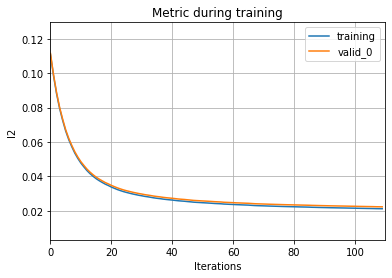

In [ ]:
lgb.plot_metric(model)

In [ ]:
# metric 見ると itration 足りていないような気がする

In [ ]:
le_num_test

,種類,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,...,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,0,0,0,0,0,0,0,0,0,0,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
1,0,0,0,0,0,0,0,0,0,1,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
2,0,0,0,1,1,1,0,0,0,2,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
3,0,0,0,1,2,2,1,0,0,2,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
4,0,0,0,1,2,1,1,0,0,1,...,40.0,80.0,45,210,80.0,800.0,10.574828,25.04525,9.548868,140.241976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22390,0,46,528,5904,1144,5,0,0,0,1,...,60.0,200.0,4,90,80.0,300.0,0.000000,10.69045,9.511897,48.795004
22391,0,46,528,3448,1144,1,0,0,0,6,...,60.0,200.0,4,90,80.0,300.0,0.000000,10.69045,9.511897,48.795004
22392,0,46,528,5905,1144,5,0,0,0,1,...,60.0,200.0,4,90,80.0,300.0,0.000000,10.69045,9.511897,48.795004
22393,0,46,528,5906,1144,5,0,0,0,6,...,60.0,200.0,4,90,80.0,300.0,0.000000,10.69045,9.511897,48.795004


In [ ]:
test_pred = model.predict(le_num_test)

In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 8.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=2cc36adeb05ec41e727f9a9a22b777043d6bf96bbe37f2fa3ee86a73f81b2050
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import japanize_matplotlib

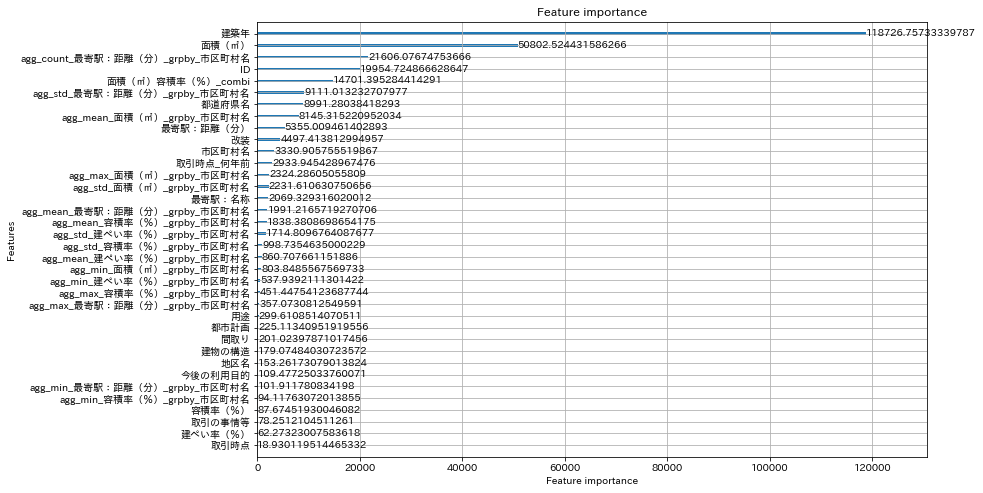

In [ ]:
lgb.plot_importance(model, figsize=(12, 8), max_num_features=50, importance_type='gain')

In [ ]:
!ls

data_explanation.xlsx  __MACOSX     sample_submission.csv  train
data.zip	       sample_data  test.csv		   train.zip


In [ ]:
sub_df = pd.read_csv('./sample_submission.csv')

In [ ]:
test_df['取引価格（総額）_log'] = test_pred

In [ ]:
sub_df = pd.merge(sub_df['ID'], test_df[['ID', '取引価格（総額）_log']], on='ID')
sub_df.to_csv('test_submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('test_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>